


- im just gonna precorrect my phenotypes for sex and generation and build a simple linear model with that, since i've been having convergence issues with the permutations
- however, it would be interesting to look at 'empirical pvalues'

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import copy

In [101]:

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# import data

In [3]:

cross = pd.read_csv('20201123_cross.csv', low_memory=False)
cross = cross.drop([0,1])
cross = cross.reset_index()

cross = cross.replace('AA', -1)
cross = cross.replace('AB', 0)
cross = cross.replace('BB', 1)
cross = cross.replace('-', np.nan)

cross.GENERATION = ['F'+str(i) for i in cross.GENERATION]
cross.DAM = ['D'+str(i) for i in cross.DAM]

cross = cross.loc[cross.BW8.isna()==False]
cross.BW8 = cross.BW8.astype(int)
cross.SEX = cross.SEX.astype(int)


cnew = []
for i in cross.columns:
    if '-' in i:
        ni = 'mrk_'+'_'.join(i.split('-'))
    else:
        ni = i
    cnew.append(ni)
    
cross.columns = cnew


cross_markers = [i for i in cross.columns if i.startswith('mrk')]


# build model

In [4]:

def make_chicken_model(marker, data, pheno='BW8',):
    #drop all individuals where marker is missing
    subset = data.loc[data[marker].isna()==False] 
    
    md = smf.mixedlm("{pheno} ~ {marker}+ SEX".format(pheno=pheno, marker=marker), data=subset, groups='GENERATION')
    try:
        mdf = md.fit()
        return marker, mdf.pvalues[marker], mdf
    except:
        #print('linalgerror at marker {marker}'.format(marker=marker) ) 
        return marker, np.nan, None

# extract residuals

In [5]:
pheno = 'BW8'
data = cross
md = smf.mixedlm("{pheno} ~ SEX".format(pheno=pheno), data=data, groups='GENERATION')
mdf = md.fit()

In [6]:
cross['precorr_bw8'] = mdf.resid

In [7]:
def make_ols(marker, data, pheno):
    subset = data.loc[data[marker].isna()==False]
    model = smf.ols('{pheno} ~ {marker}'.format(pheno=pheno, marker=marker), data=data)
    mdf = model.fit()
    return marker, mdf.pvalues[marker], mdf

In [61]:
def run_model(cross):
    cross_markers = [i for i in cross.columns if i.startswith('mrk_')]
    pvals = {}
    for marker in cross_markers:
        m, p, model = make_ols(marker=marker, data=cross, pheno='precorr_bw8')
        pvals[m]={'pvalue':p, 'model':model}
        
    pval2csv = []
    for key, item in pvals.items():
        mrk = "-".join(key.lstrip('mrk_').split('_'))
        pval = item['pvalue']
        ni = [mrk, pval]
        pval2csv.append(ni)
    
    
    return pval2csv

In [91]:
true_res = run_model(cross=cross)

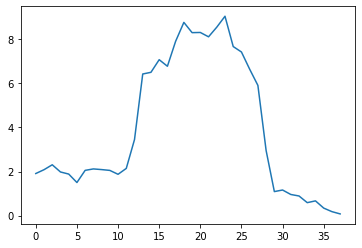

In [10]:
plt.plot(pd.DataFrame(true_res).index, -1 * np.log10(pd.DataFrame(true_res)[1]))

In [34]:
def run_permutation(i):
    crossloc = copy.deepcopy(cross)
    arrbw = np.array(crossloc['precorr_bw8'])
    np.random.shuffle(arrbw)
    crossloc['precorr_bw8'] = arrbw
    #return crossloc['BW8']
    pvals = run_model(cross = crossloc)
    #perm_dict[i] = pvals
    return pvals

In [12]:
perm_dict = {}
import warnings

#with warnings.catch_warnings():
    #warnings.simplefilter("ignore", category='ConvergenceWarning')
for i in range(3):
    j,k = run_permutation(i)
    perm_dict[j]=k
    

In [ ]:
#perm_dict[1]

In [ ]:
pd.DataFrame(perm_dict[0])[1].min()

In [31]:
from multiprocessing import Pool, TimeoutError
import time
import os


In [62]:
f = run_permutation
num = 10_000
perm = []

# start 4 worker processes
with Pool(processes=85) as pool:

    # print "[0, 1, 4,..., 81]"
    #print(pool.map(f, range(num)))

    # print same numbers in arbitrary order
    for i in pool.imap_unordered(f, range(num)):
        perm.append(i)

    # evaluate "f(20)" asynchronously
    #res = pool.apply_async(f, (20,))      # runs in *only* one process
    #print(res.get(timeout=1))             # prints "400"

    
# exiting the 'with'-block has stopped the pool
print("Now the pool is closed and no longer available")

Now the pool is closed and no longer available


In [63]:
for i, k in enumerate(perm):
    if i == 0:
        a = pd.DataFrame(k)
    else:
        b = pd.DataFrame(k)
        a = pd.merge(a, b , on=0)

In [64]:
a.to_csv('20201126_ols_permut_10k.csv')

In [66]:
a.index = a[0]

In [67]:
del(a[0])

In [68]:
a[]

,1_x,1_y,1_x,1_y,1_x,1_y,1_x,1_y,1_x,1_y,...,1_x,1_y,1_x,1_y,1_x,1_y,1_x,1_y,1_x,1_y
0,,,,,,,,,,,,,,,,,,,,,
1-0,0.367241,0.367241,0.367241,0.367241,0.367241,0.367241,0.367241,0.367241,0.367241,0.367241,...,0.262368,0.262368,0.262368,0.262368,0.983552,0.262368,0.262368,0.262368,0.262368,0.262368
1-1,0.473942,0.473942,0.473942,0.473942,0.473942,0.473942,0.473942,0.473942,0.473942,0.473942,...,0.169585,0.169585,0.169585,0.169585,0.846118,0.169585,0.169585,0.169585,0.169585,0.169585
1-2,0.362529,0.362529,0.362529,0.362529,0.362529,0.362529,0.362529,0.362529,0.362529,0.362529,...,0.227120,0.227120,0.227120,0.227120,0.592448,0.227120,0.227120,0.227120,0.227120,0.227120
1-3,0.292232,0.292232,0.292232,0.292232,0.292232,0.292232,0.292232,0.292232,0.292232,0.292232,...,0.239385,0.239385,0.239385,0.239385,0.670518,0.239385,0.239385,0.239385,0.239385,0.239385
1-4,0.365012,0.365012,0.365012,0.365012,0.365012,0.365012,0.365012,0.365012,0.365012,0.365012,...,0.552850,0.552850,0.552850,0.552850,0.317007,0.552850,0.552850,0.552850,0.552850,0.552850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30-1,0.221838,0.221838,0.221838,0.221838,0.221838,0.221838,0.221838,0.221838,0.221838,0.221838,...,0.016590,0.016590,0.016590,0.016590,0.792366,0.016590,0.016590,0.016590,0.016590,0.016590
30-2,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,...,0.128146,0.128146,0.128146,0.128146,0.519638,0.128146,0.128146,0.128146,0.128146,0.128146
30-3,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,...,0.128146,0.128146,0.128146,0.128146,0.519638,0.128146,0.128146,0.128146,0.128146,0.128146


In [92]:
true_res = pd.DataFrame(true_res)


In [93]:
true_res.index = true_res[0]

In [95]:
del(true_res[0])

In [96]:
true_res.columns = ['result']

In [97]:
b = pd.merge(true_res, a, how='inner', left_index=True, right_index=True)

In [98]:
b= b.T

In [99]:
b

,1-0,1-1,1-2,1-3,1-4,1-5,1-6,1-7,1-8,1-9,...,29-3,29-4,29-5,29-6,30-0,30-1,30-2,30-3,30-4,30-5
result,0.660398,0.594089,0.358951,0.246586,0.576479,0.588863,0.740255,0.985360,0.877515,0.978971,...,0.131803,0.137323,0.179741,0.499938,0.046239,0.125204,0.082956,0.082956,0.087995,0.095244
1_x,0.367241,0.473942,0.362529,0.292232,0.365012,0.349682,0.382302,0.521845,0.192855,0.117650,...,0.362399,0.790755,0.541978,0.943023,0.376365,0.221838,0.278569,0.278569,0.242898,0.247213
1_y,0.367241,0.473942,0.362529,0.292232,0.365012,0.349682,0.382302,0.521845,0.192855,0.117650,...,0.362399,0.790755,0.541978,0.943023,0.376365,0.221838,0.278569,0.278569,0.242898,0.247213
1_x,0.367241,0.473942,0.362529,0.292232,0.365012,0.349682,0.382302,0.521845,0.192855,0.117650,...,0.362399,0.790755,0.541978,0.943023,0.376365,0.221838,0.278569,0.278569,0.242898,0.247213
1_y,0.367241,0.473942,0.362529,0.292232,0.365012,0.349682,0.382302,0.521845,0.192855,0.117650,...,0.362399,0.790755,0.541978,0.943023,0.376365,0.221838,0.278569,0.278569,0.242898,0.247213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_y,0.262368,0.169585,0.227120,0.239385,0.552850,0.572133,0.481670,0.352547,0.159542,0.171138,...,0.616072,0.920976,0.989071,0.499994,0.053855,0.016590,0.128146,0.128146,0.153245,0.197657
1_x,0.262368,0.169585,0.227120,0.239385,0.552850,0.572133,0.481670,0.352547,0.159542,0.171138,...,0.616072,0.920976,0.989071,0.499994,0.053855,0.016590,0.128146,0.128146,0.153245,0.197657
1_y,0.262368,0.169585,0.227120,0.239385,0.552850,0.572133,0.481670,0.352547,0.159542,0.171138,...,0.616072,0.920976,0.989071,0.499994,0.053855,0.016590,0.128146,0.128146,0.153245,0.197657
1_x,0.262368,0.169585,0.227120,0.239385,0.552850,0.572133,0.481670,0.352547,0.159542,0.171138,...,0.616072,0.920976,0.989071,0.499994,0.053855,0.016590,0.128146,0.128146,0.153245,0.197657


In [171]:
result_rank = []
for marker in b.columns:
   
    c = b[marker].rank(method='first')
    r = c['result']
    n = 10_000-r
    
    result_rank.append([marker, n])
    #frac = r/10_000
    #percentile = frac*100
    

In [172]:
rank_df = pd.DataFrame(result_rank)

(0.0, 9.934173691602423)

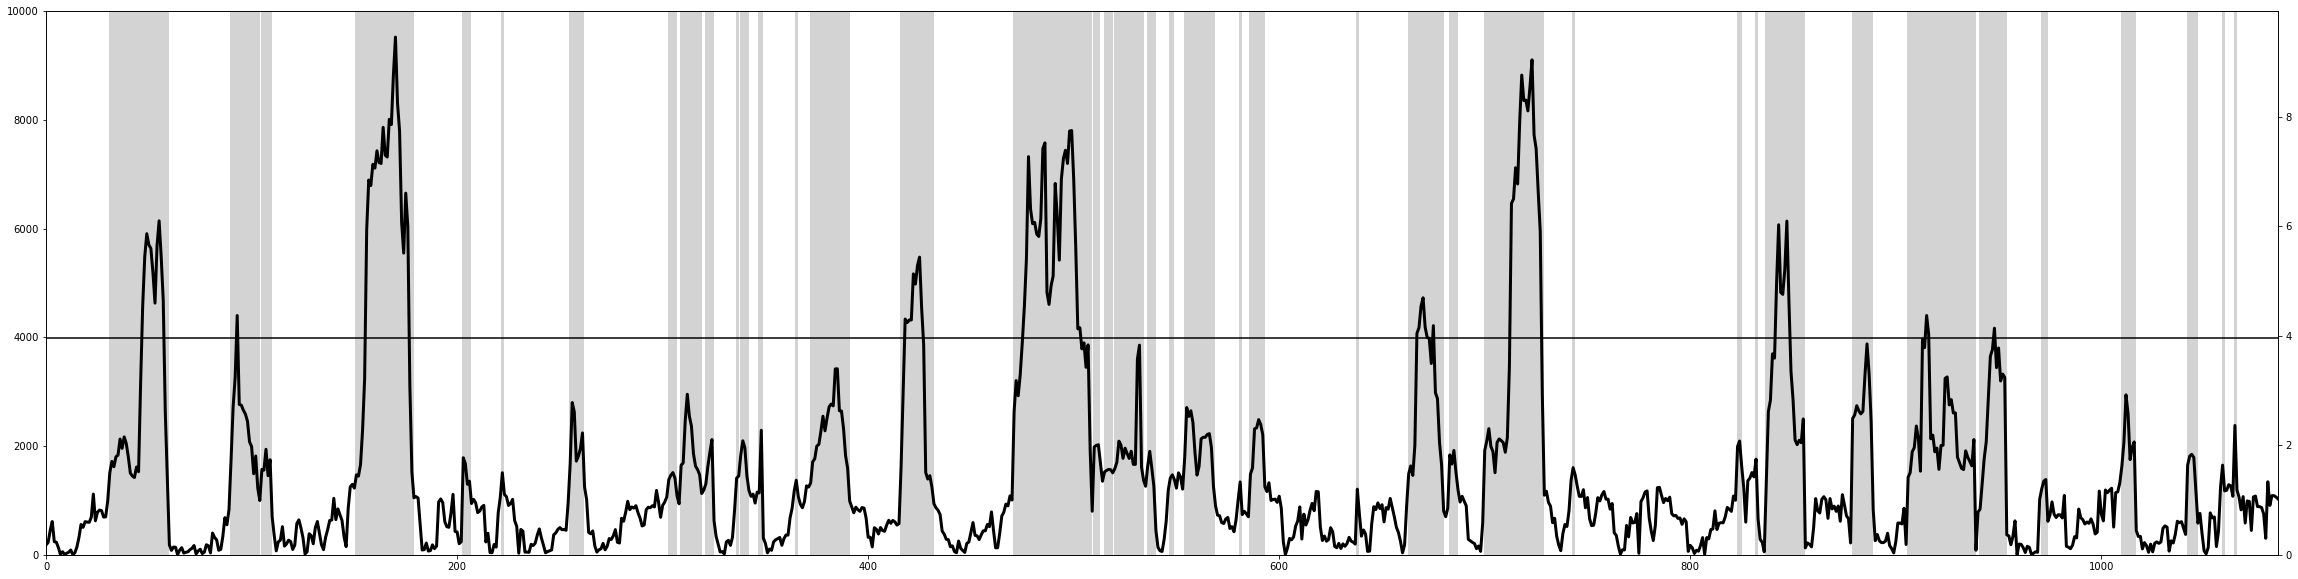

In [234]:
fig, ax = plt.subplots(ncols=1, nrows = 1, figsize=(40,10))

#ax.plot(rank_df.index, rank_df[1], color='teal')
ax2 = ax.twinx()
ax2.plot(rank_df.index, -1*np.log10(true_res['result']), color='black', lw=3)
ax2.axhline(3.962573502059376, color='black')
ax.set_xlim(0, np.max(rank_df.index))
ax.set_ylim(0,10_000)



#ax.fill_between(rank_df.index, rank_df[1], 0,
#                 facecolor="teal", #the fill color,
#                 color='teal' ,# The outline color
#                 alpha=0.5)          # Transparency of the fill


#ax.fill_between(rank_df.index, rank_df[1], 10_000,
#                 facecolor="red", #the fill color,
#                 color='red' ,# The outline color
#                 alpha=0.5)     

where = [i for i in rank_df.index if rank_df.iloc[i][1]>9500 ]
for i in where:
    ax.axvline(i, color='lightgrey', zorder=0 ,lw=3)
ax2.set_ylim(0,)

In [214]:
len(where)

384

In [151]:
#min_p = []
#for permutation in a.columns:
#    min_p.append(np.min(a[permutation]))

KeyboardInterrupt: 

In [152]:
def get_min(marker):
    return(np.min(a[marker]))


In [155]:
a.columns = [i for i in range(len(a.columns))]

In [156]:
a

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,,,,,,,,,,,,,,,,,,,,,
1-0,0.367241,0.367241,0.367241,0.367241,0.367241,0.367241,0.367241,0.367241,0.367241,0.367241,...,0.262368,0.262368,0.262368,0.262368,0.983552,0.262368,0.262368,0.262368,0.262368,0.262368
1-1,0.473942,0.473942,0.473942,0.473942,0.473942,0.473942,0.473942,0.473942,0.473942,0.473942,...,0.169585,0.169585,0.169585,0.169585,0.846118,0.169585,0.169585,0.169585,0.169585,0.169585
1-2,0.362529,0.362529,0.362529,0.362529,0.362529,0.362529,0.362529,0.362529,0.362529,0.362529,...,0.227120,0.227120,0.227120,0.227120,0.592448,0.227120,0.227120,0.227120,0.227120,0.227120
1-3,0.292232,0.292232,0.292232,0.292232,0.292232,0.292232,0.292232,0.292232,0.292232,0.292232,...,0.239385,0.239385,0.239385,0.239385,0.670518,0.239385,0.239385,0.239385,0.239385,0.239385
1-4,0.365012,0.365012,0.365012,0.365012,0.365012,0.365012,0.365012,0.365012,0.365012,0.365012,...,0.552850,0.552850,0.552850,0.552850,0.317007,0.552850,0.552850,0.552850,0.552850,0.552850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30-1,0.221838,0.221838,0.221838,0.221838,0.221838,0.221838,0.221838,0.221838,0.221838,0.221838,...,0.016590,0.016590,0.016590,0.016590,0.792366,0.016590,0.016590,0.016590,0.016590,0.016590
30-2,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,...,0.128146,0.128146,0.128146,0.128146,0.519638,0.128146,0.128146,0.128146,0.128146,0.128146
30-3,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,0.278569,...,0.128146,0.128146,0.128146,0.128146,0.519638,0.128146,0.128146,0.128146,0.128146,0.128146


In [159]:



f = get_min
num = 10_000
min_p = []

# start 4 worker processes
with Pool(processes=85) as pool:

    # print "[0, 1, 4,..., 81]"
    #print(pool.map(f, range(num)))

    # print same numbers in arbitrary order
    for i in pool.imap_unordered(f, a.columns):
        min_p.append(i)

    # evaluate "f(20)" asynchronously
    #res = pool.apply_async(f, (20,))      # runs in *only* one process
    #print(res.get(timeout=1))             # prints "400"

    
# exiting the 'with'-block has stopped the pool
print("Now the pool is closed and no longer available")

Now the pool is closed and no longer available


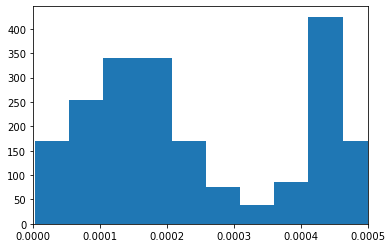

In [169]:
plt.hist(min_p, bins=300)
plt.xlim(0, 0.0005)
plt.show()

In [179]:
minp = pd.DataFrame(min_p)

In [180]:
d = minp.rank(method='first')

In [182]:
minp['rank'] = d

In [190]:
minp.loc[minp['rank'] ==500]

,0,rank
2073,0.000109,500.0


In [191]:
-1* np.log10(0.000109)

3.962573502059376

In [188]:
0.05*10_000

500.0

In [184]:
minp[]

,0,rank
0,0.001854,4942.0
1,0.001854,4943.0
2,0.001854,4944.0
3,0.001854,4945.0
4,0.001854,4946.0
...,...,...
9995,0.004320,7118.0
9996,0.000268,1350.0
9997,0.001304,3776.0
9998,0.001304,3777.0


In [132]:
result_rank

[['1-0', 3298.0]]

In [119]:
c.loc['result']

6702.0

In [120]:
6702/10_000

0.6702

In [121]:
c = b['4-15'].rank()

In [123]:
c['result']

1.0

In [129]:
(1/10_000)*100

0.01